In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import Vocaburary, TextGCN

import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

from IPython.display import clear_output
import os
import pickle

c:\Users\Wen2Tee5\Desktop\Postgraduate\final\finalEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCH = 300
HIDDEN_DIM = 200
SAVE_PATH = './result/eta_d_effect_gt_1.result'

In [3]:
dataset_names = {
    "20NewsGroup": "20NG",
    "MR":"mr",
    "Ohsumed":"ohsumed_single_23",
    "R52":"R52",
    "R8":"R8"
}
all_keys = [k for k in dataset_names.keys()]

In [4]:
eta_ds = np.arange(0., 10, 0.5)
# eta_ds = eta_ds[::-1]
eta_w = 1.0
eta_c = 1.0
w_results = {
    k:{
        'BEST_ACC': []
       }
       for k in all_keys
}

In [5]:
if not os.path.isfile(SAVE_PATH):
    for key in all_keys:
        clear_output()
        print(f'Current Dataset {key}')
        dir_name = dataset_names[key]
        dict_data = torch.load(f'./ProcessedData/{dir_name}/WholeGraphDict.gh')
        voc : Vocaburary = dict_data['voc']
        whole_graph = dict_data['whole_graph'].cuda()
        word_num = dict_data['W']
        label_num = dict_data['L']
        doc_num = dict_data['D']
        train_mask = dict_data['train_mask'].cuda()
        doc_Y : torch.Tensor = dict_data['doc_Y'].cuda()
        word_Y : torch.Tensor = dict_data['word_Y'].T.cuda()
        label_Y : torch.Tensor = dict_data['label_Y'].cuda()
        train_words = list(dict_data['train_word'])
        test_words = list(dict_data['test_word'])
        train_words.sort()
        test_words.sort()
        for eta_d in eta_ds:
            log = {"ACC": [], "LOSS": []}
            model = TextGCN(whole_graph.shape[0], HIDDEN_DIM, label_num).cuda()
            optim = torch.optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = torch.nn.CrossEntropyLoss()
            trainingProcess = tqdm(range(EPOCH), desc = f"eta_d = {eta_d}")
            for epoch in trainingProcess:
                total_loss = 0.
                optim.zero_grad()
                y_hat = model(whole_graph)
                doc_Y_hat = y_hat[:doc_num]
                word_Y_hat = y_hat[doc_num:-label_num]
                label_Y_hat = y_hat[doc_num+word_num :]
                doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
                word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
                label_loss = loss_fn(label_Y_hat, label_Y)
                loss = eta_d * doc_loss + eta_w * word_loss  + eta_c * label_loss
                loss.backward()
                optim.step()
                loss_val = loss.item()
                with torch.no_grad():
                    acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
                trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
                log['ACC'].append(acc_val)
                log["LOSS"].append(loss_val)
            w_results[key]['BEST_ACC'].append(max(log['ACC']) * 100.)
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(w_results, f)
else:
    with open(SAVE_PATH, 'rb') as f:
        w_results = pickle.load(f)

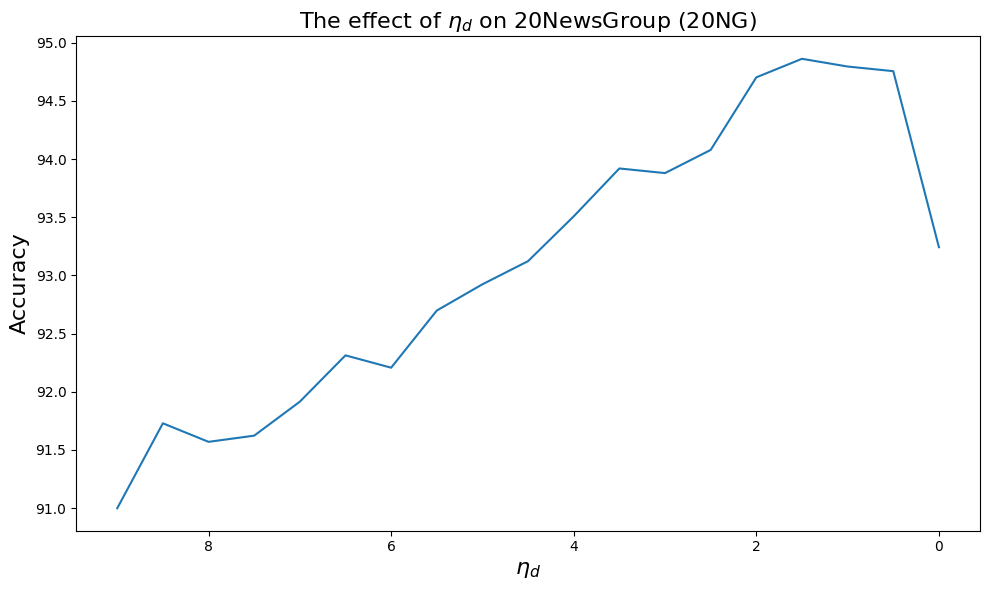

In [6]:
fig : Figure = plt.figure(figsize=(10, 6))
plt.plot(eta_ds[:-1], w_results['20NewsGroup']['BEST_ACC'][:-1])
plt.title("The effect of $\\eta_{d}$ on 20NewsGroup (20NG)", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)
plt.xlabel("$\\eta_{d}$", fontsize = 16)
plt.gca().invert_xaxis()
fig.tight_layout()
plt.show()
fig.savefig('./result/20NG_nta_d_effect_to_01.svg', transparent=True, format ='svg')

In [7]:
all_keys.remove("20NewsGroup")

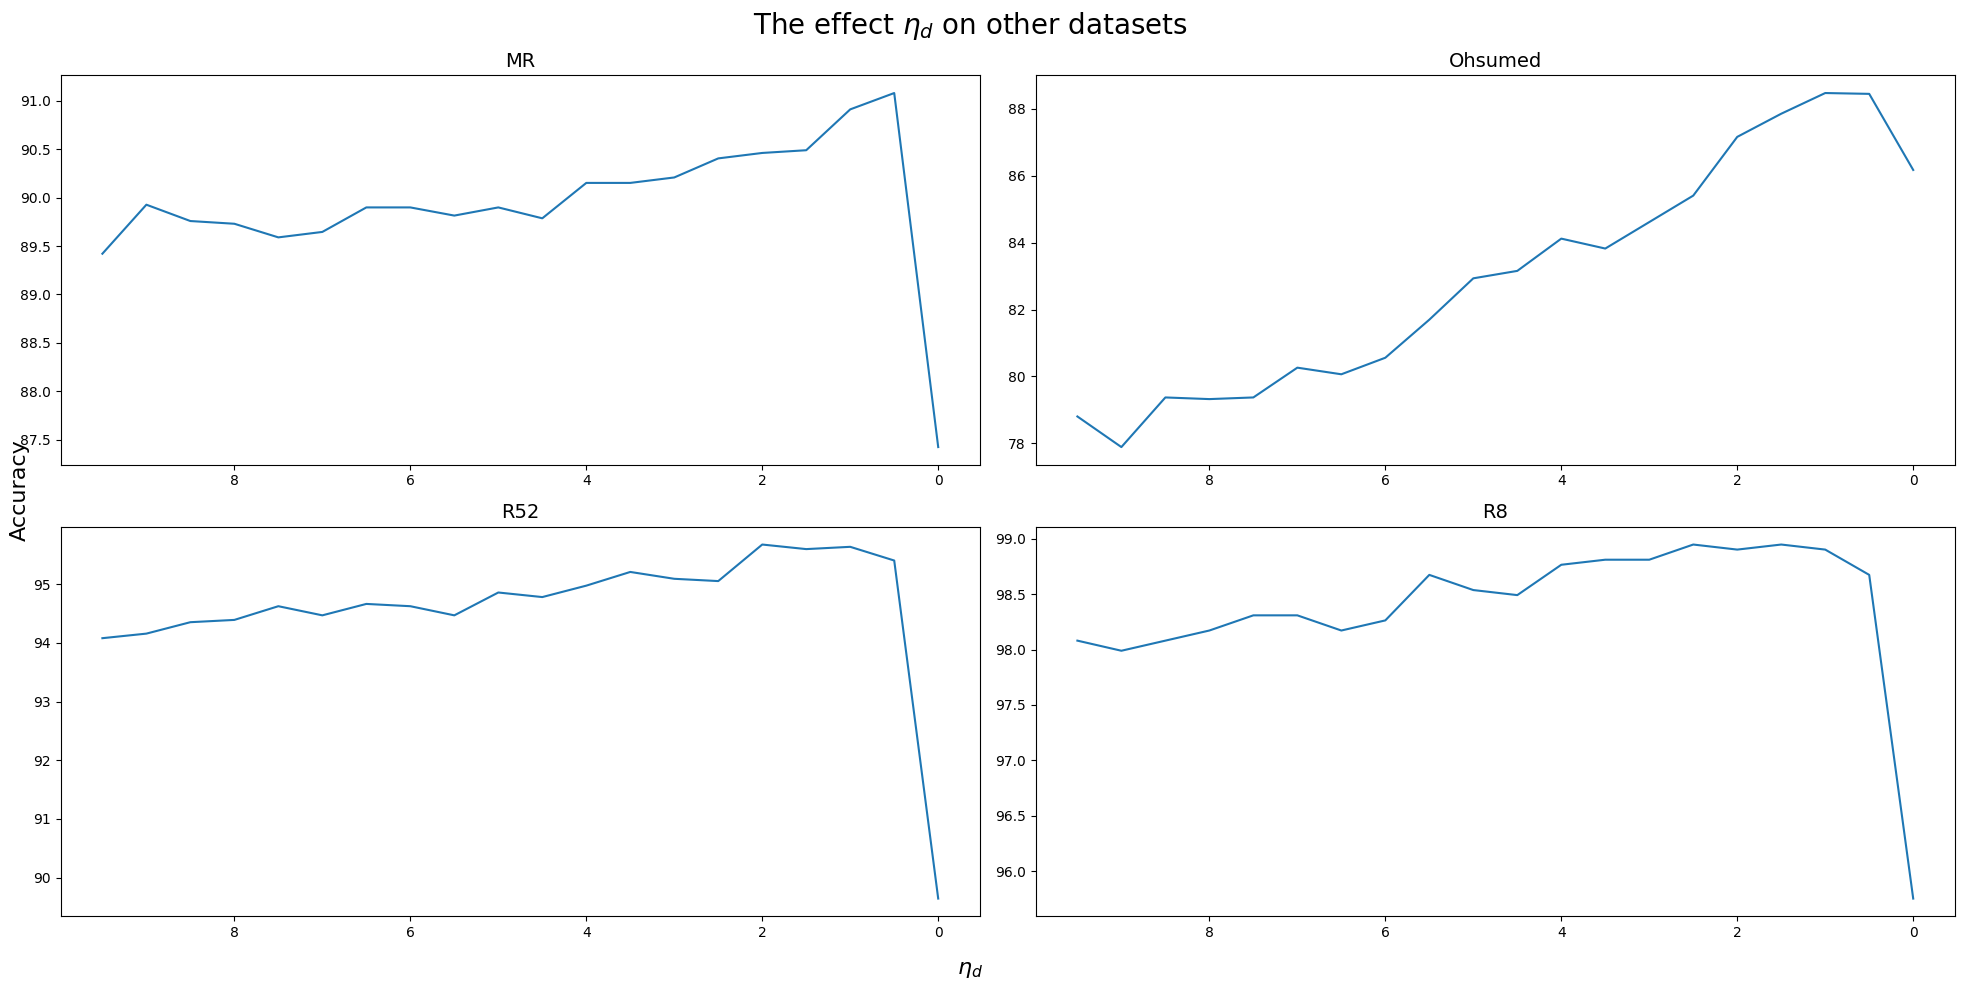

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

fig : Figure 
axs : np.ndarray[Axes]
for i, ax in enumerate(axs.flat):
    ax : Axes
    if i < 4:
        ax.set_title(all_keys[i], fontsize = 14)
        ax.invert_xaxis()
        ax.plot(eta_ds, w_results[all_keys[i]]['BEST_ACC'])
    else:
        ax.set_visible(False)
fig.set_alpha(0.0)
fig.supxlabel('$\\eta_{d}$', fontsize = 16)
fig.supylabel('Accuracy', fontsize = 16)   
fig.suptitle(t = "The effect $\\eta_{d}$ on other datasets", fontsize = 20)
fig.tight_layout()
fig.savefig('./result/the_other_eta_d_effect.svg', transparent=True, format = 'svg')
plt.show()

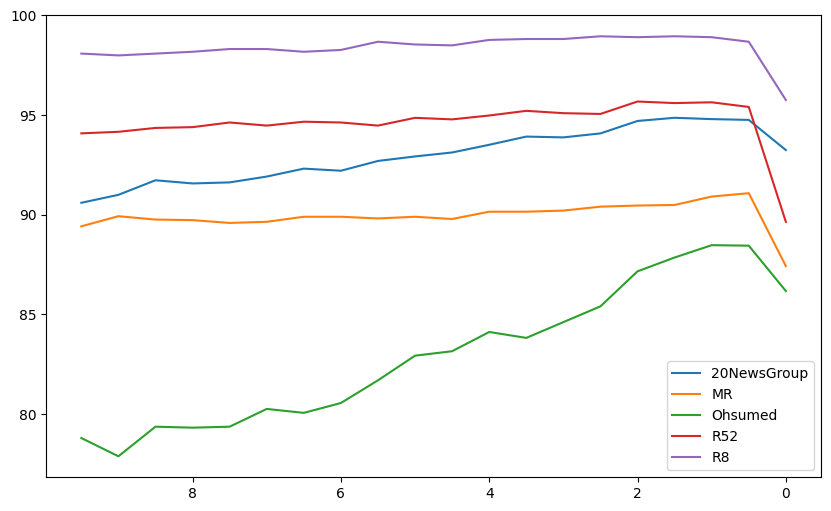

In [9]:
plt.figure(figsize=(10. , 6.))
for dataset, data in w_results.items():
    plt.plot(eta_ds, data['BEST_ACC'], label = dataset)
    plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [10]:
processed_data = {}
processed_data['eta_d'] = eta_ds[2:]
for key, data in w_results.items():
    processed_data[key] = data['BEST_ACC'][2:]

In [11]:
df = pd.DataFrame(processed_data)

In [12]:
df = df.reindex(columns=['eta_d','MR', 'R8', 'R52', 'Ohsumed', '20NewsGroup'])
df = df.rename(columns={"20NewsGroup" : "20NG"})

In [14]:
df

,eta_d,MR,R8,R52,Ohsumed,20NG
0,1.0,90.911651,98.903608,95.638627,88.473904,94.795537
1,1.5,90.489590,98.949289,95.599687,87.855554,94.861925
2,2.0,90.461451,98.903608,95.677572,87.162995,94.702601
3,2.5,90.405178,98.949289,95.054519,85.406876,94.078600
4,3.0,90.208215,98.812240,95.093459,84.615386,93.879449
5,3.5,90.151942,98.812240,95.210278,83.823895,93.919277
6,4.0,90.151942,98.766559,94.976634,84.120703,93.507701
7,4.5,89.786154,98.492461,94.781929,83.156073,93.122679
8,5.0,89.898705,98.538142,94.859815,82.933468,92.923528
9,5.5,89.814293,98.675191,94.470406,81.696761,92.697823


In [13]:
df.to_csv('./result/eta_d_gt_1.csv', index=False)